# Lab 2 - splotowe sieci neuronowe

Sieci splotowe to szczególny przypadek sieci neuronowych, których wejście może być określone za pomocą więcej niż jednego wymiaru.

Dane wejściowe (najczęściej obrazy kolorowe lub monochromatyczne) są poddawane operacji wielokrotnego splotu w celu wyodrębnienia charakterystycznych wzorców (cech) i transformacji ich do postaci wektora. 

Schemat splotu jednowymiarowego:
$(f * g)[x] = \sum_{i = -∞}^{+∞} f[x - i] g[i]$

Schemat splotu dwuwymiarowego:
$(f * g)[x, y] = \sum_{i = -∞}^{+∞} \sum_{j = -∞}^{+∞} f[x - i, y - j] g[i, j]$

gdzie: 
- $x, y$ - współrzędne punktu na obiekcie wejściowym
- $f$ - obiekt wejściowy
- $g$ - filtr splotu

W warstwach splotowych zachodzi także operacja poolingu. Dla każdego okna splotu polega ona na wyborze:
- wartości maksymalnej - max pooling
- wartości średniej - avg pooling



Każda warstwa splotowa składa się z n filtrów, które tworzą n map cech, czyli n tymczasowych obrazów z wykrytymi wzorcami przez każdy filtr. 

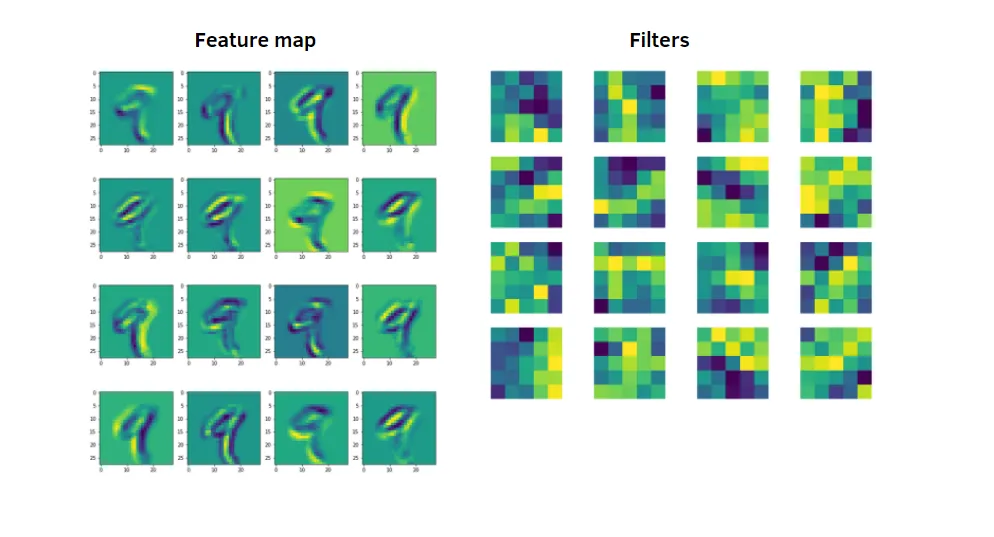

Na podstawie propagacji wstecznej filtry warstw spolotowych są również korygowane:

$O^{grad}_i = \frac{\delta A}{M_i}$

$w_i^{grad} = I_{1,1} \cdot O_{1,1}^{grad} + I_{1,2} \cdot O_{1,2}^{grad} + ... + I_{m,n} \cdot O_{m,n}^{grad}$

$k_i = k_i - \alpha \cdot w_i^{grad}$

gdzie:
- $O_{grad}^i$ - gradient $i$-tej mapy cech
- $A$ - funkcja przydzielająca predykcję w operacji splotu
- $M_i$ - predykcja warstwy splotowej
- $m, n$ - wymiary obrazu wejściowego
- $k_i$ - $i$-ty filtr operacji splotu

## Sieć splotowa

Typowa sieć splotowa składa się z następujących komponentów:
- splot (lub kilka następujących po sobie)
- pooling
- znów splot i pooling
- flatten (spłaszczanie znalezionych wzorców do postaci wektora)
- dense (klasyczna gęsta sieć neuronowa)
- wyjście

Zazwyczaj wykorzystuje się minimum dwie warstwy splotowe. Każda z kolejnych rozpoznaje bardziej skomplikowane wzorce.

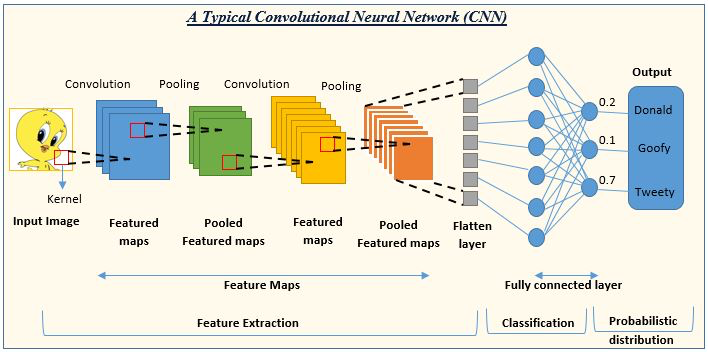

## Budowa splotowej sieci neuronowej z wykorzystaniem Tensorflow

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [ ]:
!unzip -e /content/kagglecatsanddogs_5340.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm

### Przygotowanie danych

In [ ]:
data_dir = '/content/PetImages'

In [ ]:
for path in tqdm(Path(data_dir).glob('**/*.jpg')):
  try:
    mpimg.imread(path)
  except:
    path.unlink()

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=50, 
    horizontal_flip=True, 
    validation_split=0.2,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=[1, 1.2],
)

In [ ]:
input_size = (150, 150)

train_ds = img_gen.flow_from_directory(
  data_dir,
  subset='training',
  target_size=input_size,
  batch_size=16,
  class_mode='categorical'
)

val_ds = img_gen.flow_from_directory(
  data_dir,
  subset='validation',
  target_size=input_size,
  batch_size=16,
  class_mode='categorical'
)

### Architektura sieci neuronowej

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
  ])

In [ ]:
model.summary()

In [ ]:
plot_model(model)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['binary_accuracy']
)

### Callbacks

In [ ]:
check_point_best_model = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=600, 
    shuffle=True, 
    callbacks=[
        check_point_best_model, 
        early_stopping
    ]
  )

## Wykorzystanie gotowych architektur sieci neuronowych

W bibliotece Tensorflow znajdują się wbudowane implementacje popularnych architektur sieci splotowych, takich jak:
- Resnet
- VGG
- Xception
- Inception
- MobileNet
- DenseNet
- NasNet
- EfficientNet

In [ ]:
xception = tf.keras.applications.Xception(
    weights=None,
    input_shape=(299, 299, 3),
    include_top=False
)

In [ ]:
input_size = (299, 299)

train_ds = img_gen.flow_from_directory(
  data_dir,
  subset='training',
  target_size=input_size,
  batch_size=16,
  class_mode='categorical'
)

val_ds = img_gen.flow_from_directory(
  data_dir,
  subset='validation',
  target_size=input_size,
  batch_size=16,
  class_mode='categorical'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [ ]:
model = xception

i = tf.keras.layers.Input([299, 299, 3], dtype=tf.uint8)
x = tf.cast(i, tf.float32)
x = model(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')(x)
x = tf.keras.layers.BatchNormalization(name='bn_dense_1')(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')(x)
x = tf.keras.layers.BatchNormalization(name='bn_dense_2')(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')(x)
x = tf.keras.layers.BatchNormalization(name='bn_dense_3')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=[i], outputs=[x])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['binary_accuracy']
)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=50, 
  )

## Zadania

1. Utworzyć model klasyfikujący cyfry ze zbioru MNIST. W tym celu:
- załadować dane MNIST z tensorflow.keras.datasets,
- przeskalować dane do zakresu (0–1) oraz przekształcić etykiety do formatu one-hot,
- zbudować prostą sieć splotową (np. Conv2D -> MaxPooling2D -> Flatten -> Dense),
- wytrenować model.
2. Udoskonalić model z zadania poprzedniego za pomocą następujących kroków:
- dodać kolejne warstwy splotowe oraz dropout,
- porównać jakość oryginalnego i ulepszonego modelu.
3. Utworzyć model klasyfikujący obrazy kolorowe ze zbioru CIFAR-10. W tym celu:
- załadować dane CIFAR-10 z tensorflow.keras.datasets,
- przeskalować obrazy i zakodować etykiety,
- zbudować sieć splotową do rozpoznawania klas (np. samochód, pies, samolot itd.),
4. Udoskonalić model o technikę rozszerzania zbioru danych:
- dodać operację rozszerzania zbioru danych,
- zwiększyć złożoność sieci,
- porównać wyniki z modelem z zadania poprzedniego.
5. Dokonać klasyfikacji obrazów z użyciem wstępnie wytrenowanej sieci. W tym celu:
- wybrać jeden z modeli: InceptionV3, DenseNet121, MobileNetV2 z tensorflow.keras.applications,
- wczytać model bez górnych warstw (include_top=False),
- wykorzystać zbiór danych CIFAR-10.